Notebook to try implementations/functions of the dreambooth inpainting algorithm.

In [1]:
import yaml
import itertools
import math
import os
import logging
from pathlib import Path
import wandb

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed
from huggingface_hub import create_repo, upload_folder
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer

from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    StableDiffusionPipeline,
    UNet2DConditionModel,
    # DiffusionPipeline,
    # DPMSolverMultistepScheduler,
)
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version

from sklearn.model_selection import train_test_split

In [12]:
def prepare_mask_and_masked_image(image, mask, black_mask=True, discretize_mask=True):
    image = np.array(image.convert("RGB"))
    # image = image[None].transpose(0, 3, 1, 2)
    image = image.transpose(2, 0, 1)
    image = torch.from_numpy(image).to(dtype=torch.float32) / 127.5 - 1.0

    mask = np.array(mask.convert("L"))
    mask = mask.astype(np.float32) / 255.0
    # mask = mask[None, None]
    mask = mask[None]
    if discretize_mask:
        mask[mask < 0.5] = 0
        mask[mask >= 0.5] = 1
    else:
        mask[mask < 0.0] = 0
        mask[mask >= 1.0] = 1
    mask = torch.from_numpy(mask)

    if black_mask:
        masked_image = image * (mask < 0.5) + (mask >= 0.5) * -1 if discretize_mask else image * (1 - mask)
    else:
        masked_image = image * (mask < 0.5)

    return mask, masked_image

def parse_args():
    config_path = "config_dreambooth_inpaint.yaml"
    
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Config file '{config_path}' not found.")
    
    with open(config_path, "r") as file:
        config = yaml.safe_load(file)
    
    # Convert values in config to the correct types (float or int)
    def convert_values(config_dict):
        for key, value in config_dict.items():
            # If the value is a string that can be converted to float or int, convert it
            if isinstance(value, str):
                try:
                    # Try converting to float first (for cases like '5e-6')
                    config_dict[key] = float(value) if '.' in value or 'e' in value else int(value)
                except ValueError:
                    # If conversion fails, leave as string
                    pass
            # Recursively process dicts (in case there are nested structures)
            elif isinstance(value, dict):
                convert_values(value)

    # Convert all values
    convert_values(config)

    class Args:
        def __init__(self, config_dict):
            for key, value in config_dict.items():
                setattr(self, key, value)
    
    args = Args(config)
    
    # Ensure local_rank consistency with environment variable
    env_local_rank = int(os.environ.get("LOCAL_RANK", -1))
    if hasattr(args, "local_rank") and env_local_rank != -1 and env_local_rank != args.local_rank:
        args.local_rank = env_local_rank
    
    # Validate required arguments
    if not hasattr(args, "instance_data_dir") or args.instance_data_dir is None:
        raise ValueError("You must specify a train data directory.")
        
    return args


class MSInpaintingDataset(Dataset):
    """
    Custom dataset for MS lesion inpainting. Loads paired FLAIR MRI images and corresponding lesion masks.
    A dataset to prepare the instance and class images with the prompts for fine-tuning the model.
    It pre-processes the images and the tokenizes prompts.
    """

    def __init__(
        self,
        image_paths, # List of image file paths
        mask_paths, # List of corresponding mask file paths
        instance_prompt,
        tokenizer,
        size=512,
        black_mask=True,
        discretize_mask=True,
    ):
        self.size = size
        self.tokenizer = tokenizer
        self.black_mask = black_mask
        self.discretize_mask = discretize_mask

        # self.instance_data_root = Path(instance_data_root)
        # self.mask_data_root = Path(mask_data_root)
        # if not self.instance_data_root.exists() or not self.mask_data_root.exists():
        #     raise ValueError("Instance images root or mask images root doesn't exists.")

        # self.image_paths = sorted(list(self.instance_data_root.iterdir()))
        # self.mask_paths = sorted([self.mask_data_root / img.name for img in self.image_paths]) # Corresponding masks for each image
        
        self.image_paths = image_paths  # List of image file paths
        self.mask_paths = mask_paths  # List of corresponding mask file paths


        # Ensure there are corresponding masks for each image
        assert all(mask.exists() for mask in self.mask_paths), "Some masks are missing for the images!"

        self.num_instance_images = len(self.image_paths)
        self.instance_prompt = instance_prompt
        self._length = self.num_instance_images

        self.image_transforms_resize_and_crop = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size),
            ]
        )

        self.image_transforms = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return self._length

    # def __getitem__(self, index):
    #     example = {}

    #     # Load instance image
    #     # instance_image = Image.open(self.images_path[index % self.num_instance_images])
    #     instance_image = Image.open(self.image_paths[index]).convert("RGB")
    #     instance_image = self.image_transforms_resize_and_crop(instance_image)

    #     # Load lesion mask
    #     lesion_mask = Image.open(self.mask_paths[index]).convert("L")
    #     lesion_mask = self.image_transforms_resize_and_crop(lesion_mask)
    #     lesion_mask = transforms.ToTensor()(lesion_mask)
    #     lesion_mask = (lesion_mask > 0.5).float()

    #     # Create masked image
    #     instance_image_tensor = self.image_transforms(instance_image)
    #     lesion_mask_expanded = lesion_mask.expand_as(instance_image_tensor) # Expand mask to the same shape as the image (3 channels)
    #     masked_image = instance_image_tensor * (1 - lesion_mask_expanded)

    #     # Store processed data
    #     example["PIL_images"] = instance_image
    #     example["instance_images"] = instance_image_tensor
    #     example["lesion_masks"] = lesion_mask
    #     example["masked_images"] = masked_image

    #     # Encode text prompt
    #     example["instance_prompt_ids"] = self.tokenizer(
    #         self.instance_prompt,
    #         padding="do_not_pad",
    #         truncation=True,
    #         max_length=self.tokenizer.model_max_length,
    #     ).input_ids

    #     return example


    def __getitem__(self, index):
        example = {}
        instance_image_path = self.image_paths[index % self.num_instance_images]
        instance_image = Image.open(instance_image_path)
        if not instance_image.mode == "RGB":
            instance_image = instance_image.convert("RGB")
        instance_image = self.image_transforms_resize_and_crop(instance_image)
        instance_prompt = self.instance_prompt
        mask = Image.open(self.mask_paths[index])
        if not mask.mode == "L":
            mask = mask.convert("L")
        mask = self.image_transforms_resize_and_crop(mask)
        # prepare mask and masked image
        mask, masked_image = prepare_mask_and_masked_image(instance_image, mask, black_mask=self.black_mask, discretize_mask=self.discretize_mask)

        example["lesion_masks"] = mask
        example["masked_images"] = masked_image
        example["PIL_images"] = instance_image
        example["instance_images"] = self.image_transforms(instance_image)
        example["instance_prompt_ids"] = self.tokenizer(
            instance_prompt,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids

        return example



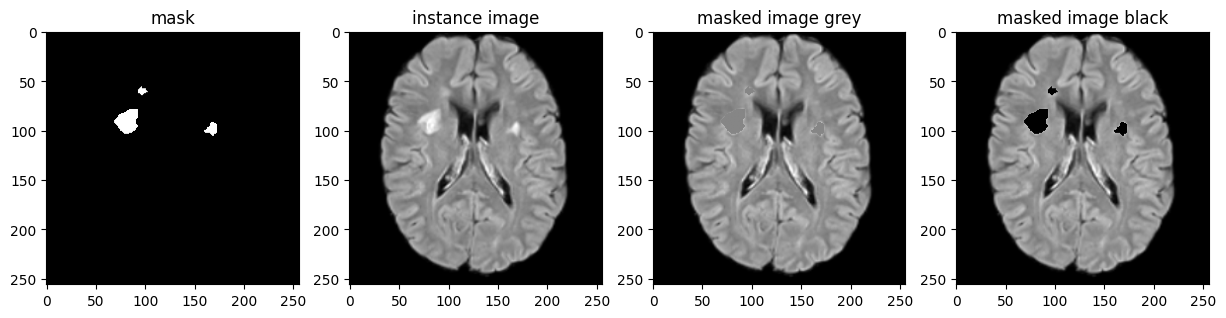

In [31]:
args = parse_args()
# Load the tokenizer
image_transforms_resize_and_crop = transforms.Compose(
    [
        transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(args.resolution),
    ]
)

image_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

# take the first image in the args.val_input_image_path and the first mask in the args.val_mask_image_path
val_input_image_path = list(Path(args.val_input_image_path).glob("*.png"))[0]
val_mask_image_path = list(Path(args.val_mask_image_path).glob("*.png"))[0]

instance_image_path = val_input_image_path
instance_image = Image.open(instance_image_path)
if not instance_image.mode == "RGB":
    instance_image = instance_image.convert("RGB")
instance_image = image_transforms_resize_and_crop(instance_image)
mask = Image.open(val_mask_image_path)
if not mask.mode == "L":
    mask = mask.convert("L")
mask_orig = image_transforms_resize_and_crop(mask)

mask, masked_image_grey = prepare_mask_and_masked_image(instance_image, mask_orig, black_mask=False)
mask, masked_image_black = prepare_mask_and_masked_image(instance_image, mask_orig, black_mask=True)

instance_image = image_transforms(instance_image)

#plot the images
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.imshow(mask[0], cmap='gray')
plt.title("mask")
plt.subplot(1, 4, 2)
plt.imshow(instance_image[0], cmap='gray')
plt.title("instance image")
plt.subplot(1, 4, 3)
plt.imshow(masked_image_grey[0], cmap='gray')
plt.title("masked image grey")
plt.subplot(1, 4, 4)
plt.imshow(masked_image_black[0], cmap='gray')
plt.title("masked image black")
plt.show()

# convert them to Image
masked_image_grey = masked_image_grey[0].numpy()

masked_image_grey = Image.fromarray(((masked_image_grey + 1.0) * 127.5).astype(np.uint8))
#convert to RGB
masked_image_grey = masked_image_grey.convert("RGB")
masked_image_grey.save("masked_image_grey.png")



torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([3, 256, 256])
[49406, 988, 534, 1015, 530, 550, 46550, 24938, 24773, 4812, 11261, 269, 49407]


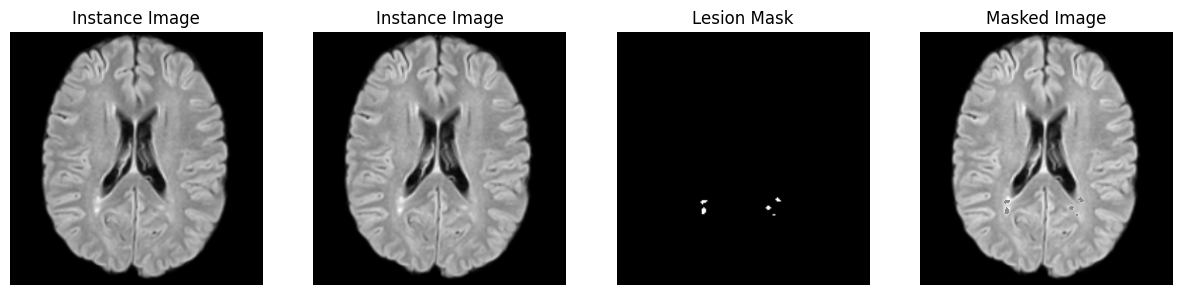

In [8]:
# get one batch of training data and plot it
train_data = train_dataset[2]
print(train_data["instance_images"].shape)
print(train_data["lesion_masks"].shape)
print(train_data["masked_images"].shape)
print(train_data["instance_prompt_ids"])
# print(train_data["PIL_images"])

from matplotlib import pyplot as plt

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.imshow(train_data["PIL_images"])
plt.title("Instance Image")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(train_data["instance_images"][1], cmap="gray")
plt.title("Instance Image")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(train_data["lesion_masks"][0], cmap="gray")
plt.title("Lesion Mask")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(train_data["masked_images"][1], cmap="gray")
plt.title("Masked Image")
plt.axis("off")

plt.show()



In [9]:
train_data["masked_images"].permute(1, 2, 0).cpu().numpy()[0].shape

(256, 3)